In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("lesson9") \
    .config("spark.driver.memory", "2g") \
    .config("spark.executor.memory", "2g") \
    .getOrCreate()

## 流动的 Word Count

netcat命令` nc -kl 9999 `向本地 9999 端口的 Socket 地址发送数据行，Spark 流处理应用，则时刻监听着本机的 9999 端口，一旦接收到数据条目，就会立即触发Word Count计算逻辑的执行。计算执行完毕之后，流处理应用再把结果打印到终端（Console）上

注意！！！

与批处理不同，只要我们不人为地中断程序，流处理应用会一直运行。以“流动的 Word Count”为例，只要我们不强制中断它，它就可以一直监听 9999 端口，接收来自那里的数据，并以实时的方式处理它`

In [ ]:
import pyspark.sql.functions as F

HOST = 'netcat'  # 远程主机host
PORT = 9999         # 监听的端口号

# 1.数据加载
df = spark.readStream.format("socket").option("host", HOST).option("port", PORT).load()

# 2.数据处理
words = df.select("word", F.explode(F.split("value", " ")).alias("word")).
wordCounts = words.groupBy("word").count()

# 3. 数据输出：Word Count结果写入到终端（Console）
query = wordCounts.writeStream.format("console").outputMode("complete").start()

query.awaitTermination()

一般来说，我们通过 readStream API 从不同类型的 Source 读取数据流、并创建 DataFrame，然后使用 DataFrame 算子处理数据，如数据的过滤、投影、分组、聚合等，最终通过 writeStream API 将处理结果，写入到不同形式的 Sink 中去

## Structured Streaming 中的计算模型

Structured Streaming 的核心思想是将实时数据流视为一个不断追加的表格。这种处理模型类似于批处理模型，用户可以使用标准的批处理查询来表达流处理计算，并且Spark会将其作为增量查询运行在这个无界的输入表格上

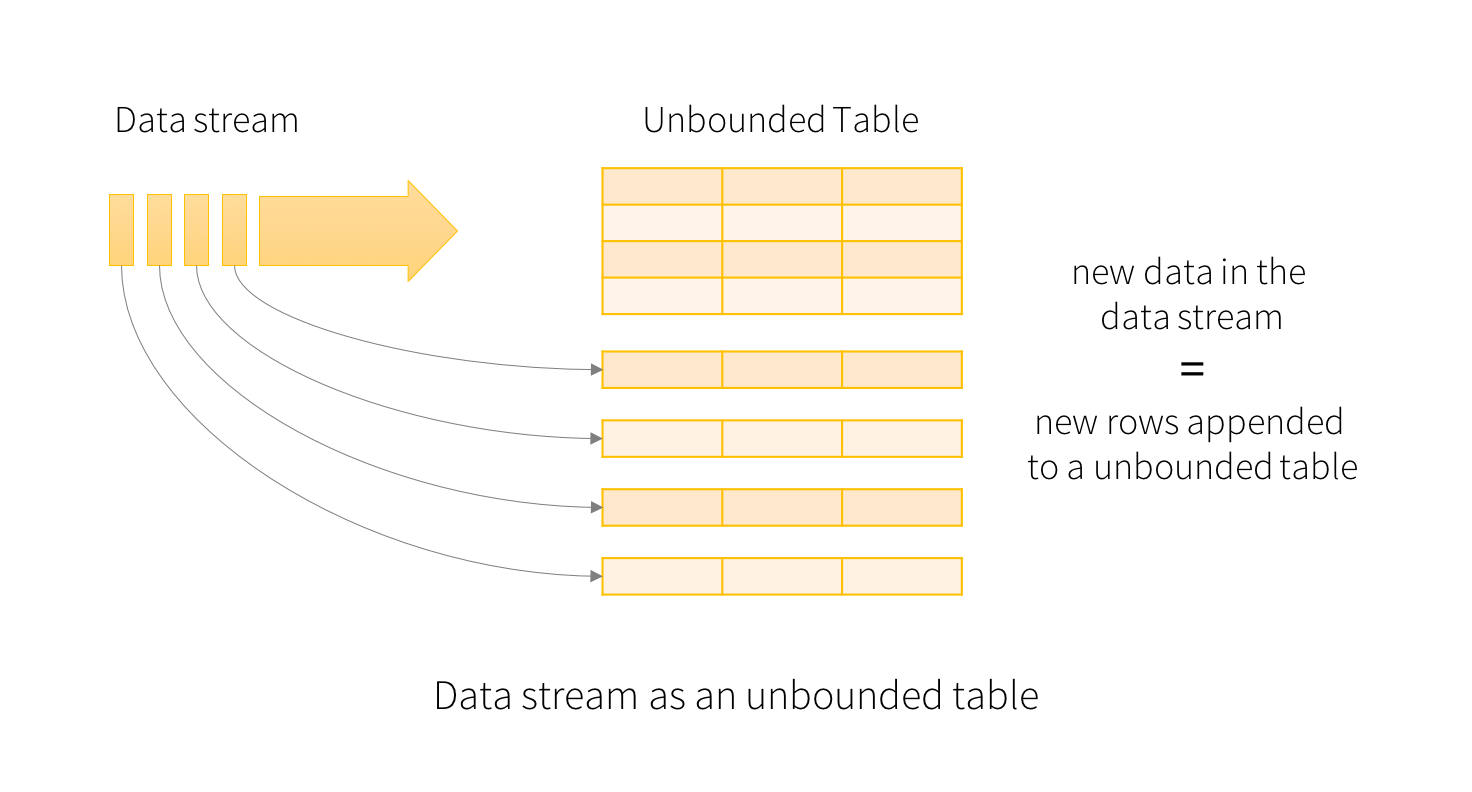

通过对输入表进行查询将生成结果表。每个Trigger（触发间隔，比如每1秒），新行都会附加到输入表中，最终更新结果表。每当结果表被更新时，将更改后的结果按照一定的输出模式行写入到结果输出sink中

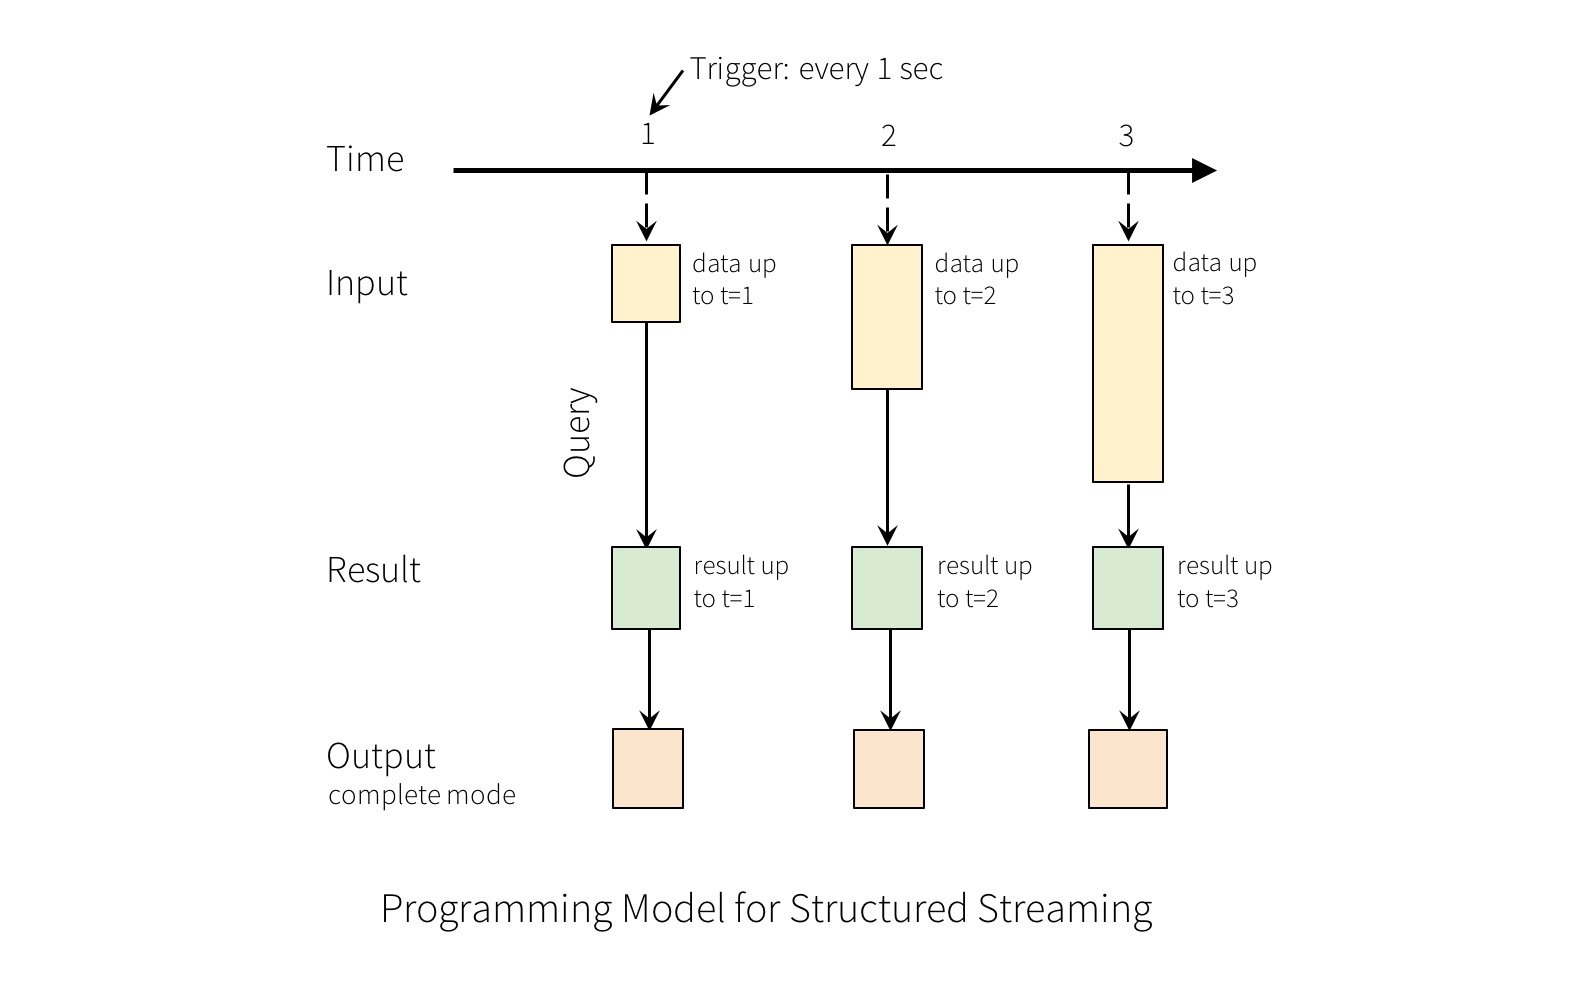

对于结果的输出 Structured Streaming 支持3种不同的输出模式，分别是 Complete mode、Append mode 和 Update mode。
* Complete mode 输出到目前为止处理过的所有数据
* Update mode 仅输出在当前批次有所更新的计算结果(包含新增)
* Append mode 仅输出当前批次中新增的计算结果

### 容错机制

对于任何一个流处理引擎来说，容错都是一项必备的能力。所谓容错，它指的是，在计算过程中出现错误（作业层面、或是任务层面，等等）的时候，流处理引擎有能力恢复被中断的计算过程，同时保证数据上的不重不漏，也即保证数据处理的一致性。

从数据一致性的角度出发，这种容错的能力，可以划分为 3 种水平：
* At most once：最多交付一次，数据存在丢失的风险；
* At least once：最少交付一次，数据存在重复的可能；
* Exactly once：交付且仅交付一次，数据不重不漏。

在数据处理上，结合容错机制，Structured Streaming 本身能够提供“At least once”的处理能力。而结合幂等的 Sink，Structured Streaming 可以实现端到端的“Exactly once”容错水平。

在默认模式下，Structured Streaming 利用 Checkpoint 机制来实现容错。Checkpoint 机制会把数据处理的元信息全部存储到开发者指定的文件系统路径，比如 HDFS 或是 Amazon S3(默认位于Spark应用程序的工作目录下的“checkpoint”文件夹)。当出现作业或是任务失败时，引擎只需要读取这些事先记录好的元信息，就可以恢复数据流的“断点续传”。

要指定 Checkpoint 目录，只需要在 writeStream API 的 option 选项中配置 checkpointLocation 即可。我们以上一讲的“流动的 Word Count”为例，代码只需要做如下修改即可

```python
df.writeStream
    .format("console")
    .option("truncate", False)
    .option("checkpointLocation", "path/to/HDFS")
    .outputMode("complete").start()
```

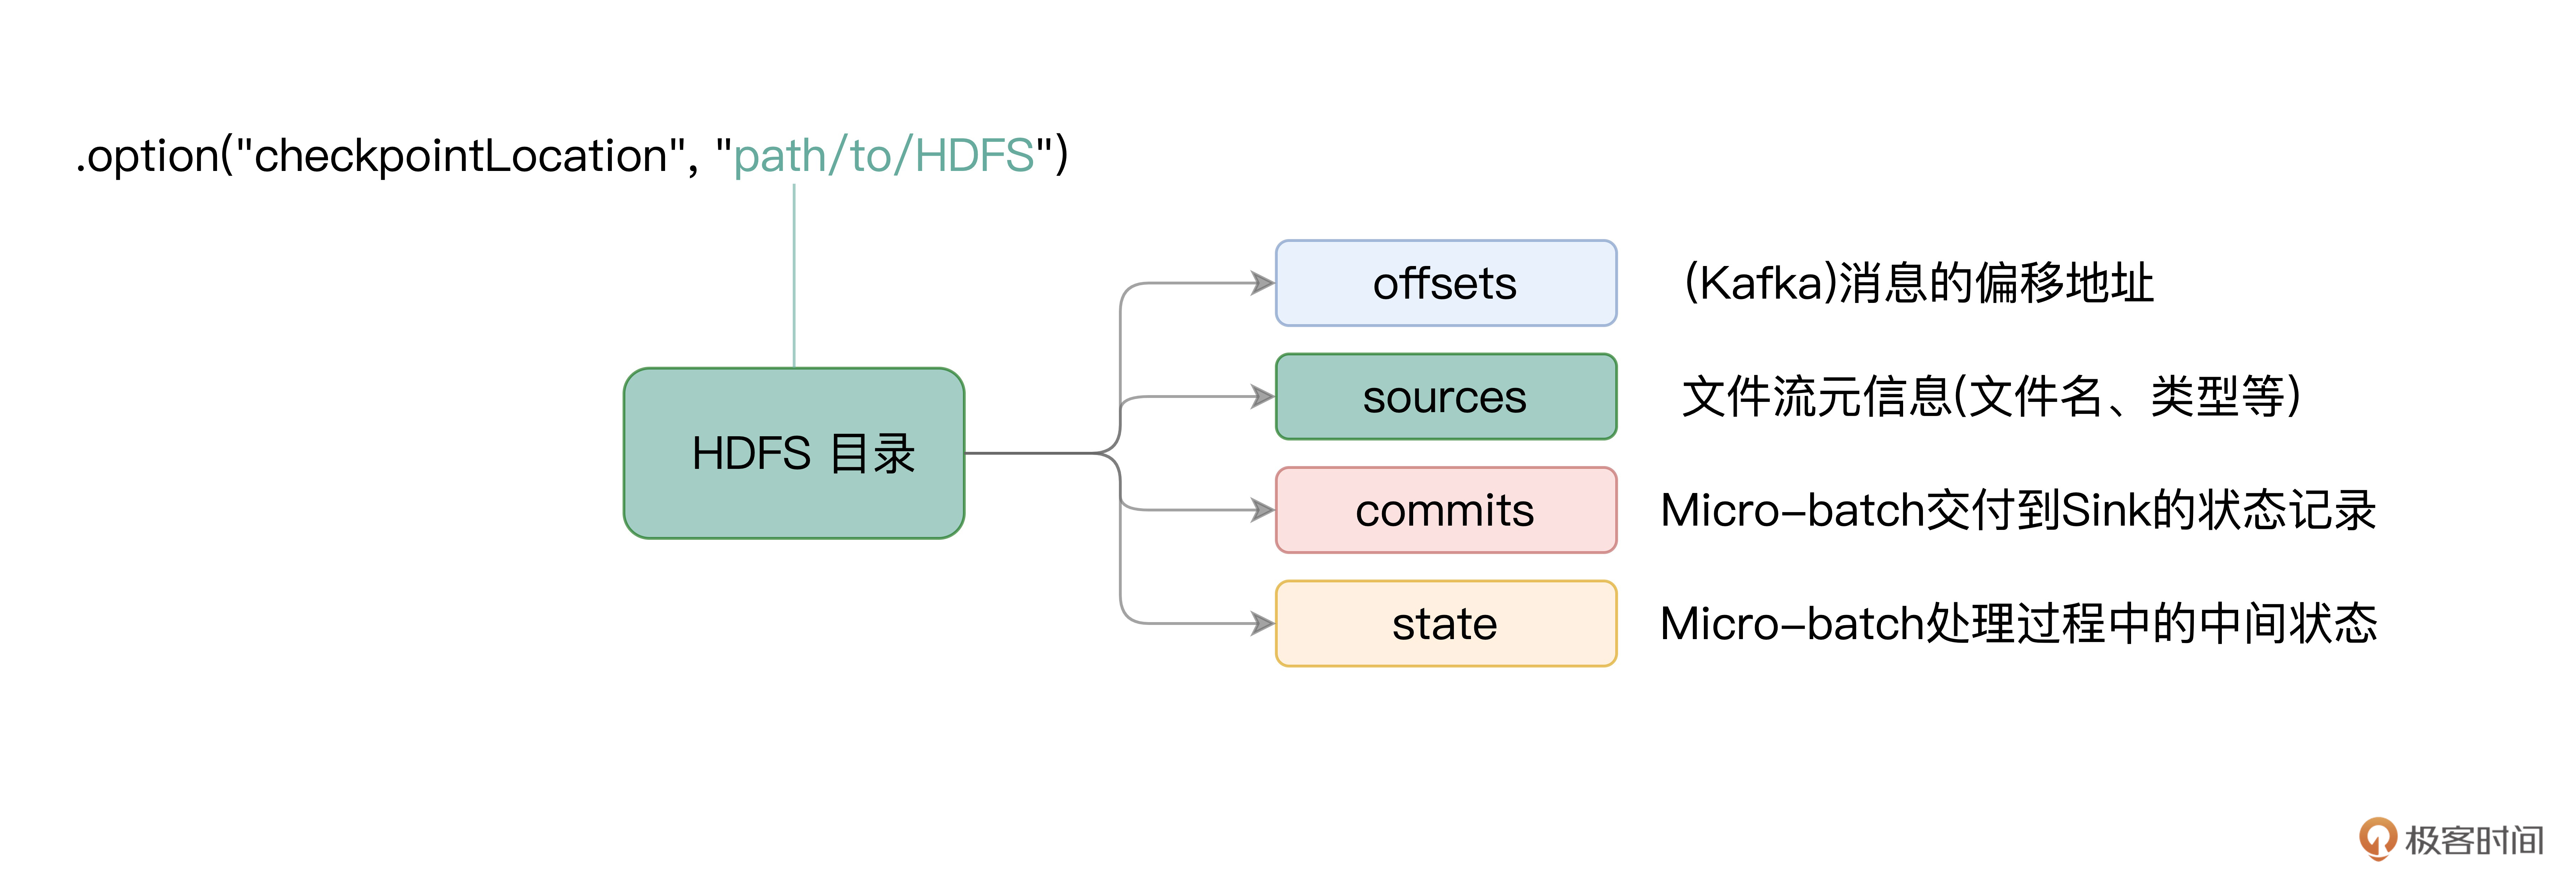

当源数据流进 Source 之后，需要先到 Checkpoint 目录下进行“报道”，然后才会被 Structured Streaming 引擎处理。毫无疑问，“报道”这一步耽搁了端到端的处理延迟，除此之外，由于每个trigger查询都会触发一个 Spark 作业，作业与任务的频繁调度会引入计算开销，因此也会带来不同程度的延迟。在运行模式与容错机制的双重加持下，Batch mode 的延迟水平往往维持在秒这个量级，在最好的情况下能达到几百毫秒左右。在实时性要求高的计算场景下，推荐使用flink计算引擎

## Window操作&Watermark

使用统一的dataframe计算入口，Spark SQL 所拥有的计算能力，Structured Streaming 都有。此外，除了基本的数据处理能力以外，为了更好地支持流计算场景，Structured Streaming 引擎还提供了一些专门针对流处理的计算能力，比如 Window 操作、Watermark 延迟数据处理

### window 操作

首先，我们需要了解事件时间的概念，它指的是消息生成的时间，比如，我们在 netcat 中敲入“Apache Spark”的时间戳是“2021-10-01 09:30:00”，那么这个时间就是消息“Apache Spark”的事件时间

所谓 Window 操作，实际上就是 Structured Streaming 引擎基于事件时间以固定间隔划定时间窗口，然后以窗口为粒度处理消息。在窗口的划分上，Structured Streaming 支持两种划分方式，一种叫做 Tumbling Window，另一种叫做 Sliding Window。我们可以用一句话来记住二者之间的区别，Tumbling Window 划分出来的时间窗口“不重不漏”，而 Sliding Window 划分出来的窗口，可能会重叠、也可能会有遗漏，如下图所示

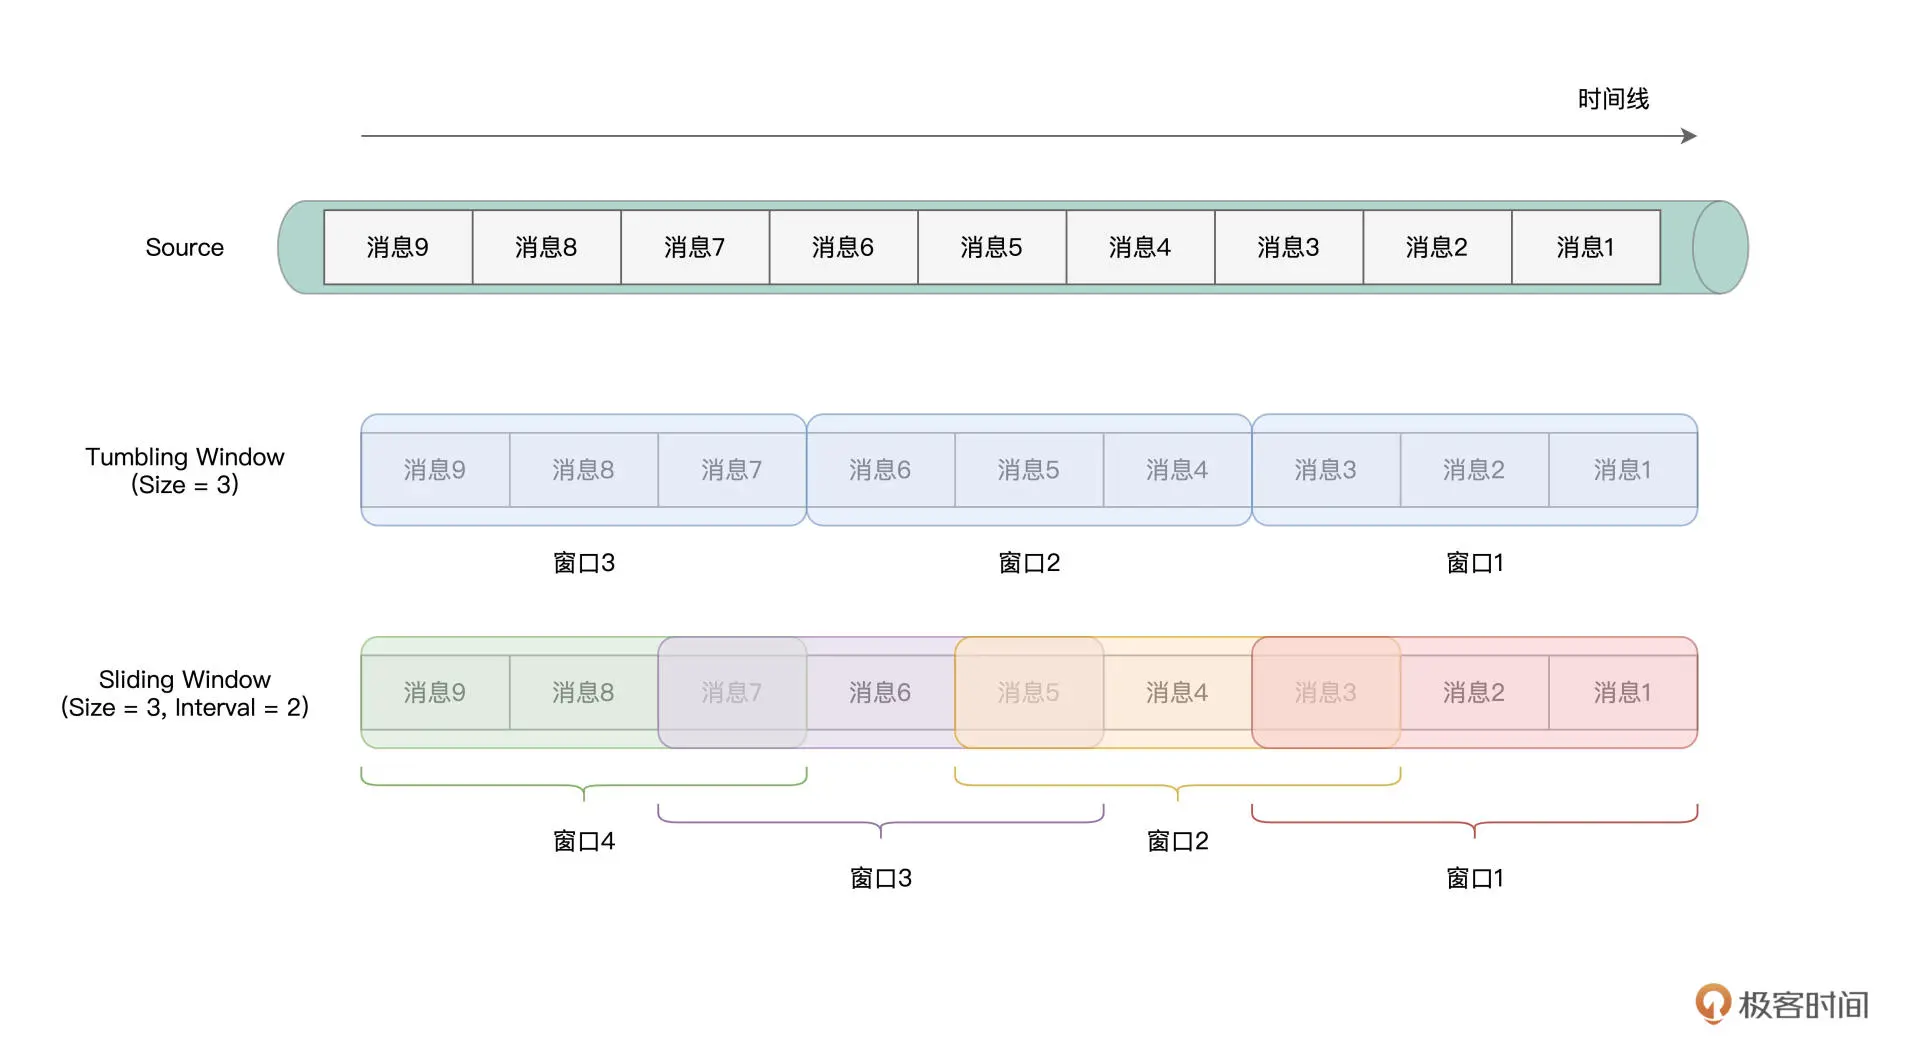

以事件时间为准，以 5 分钟为间隔，创建 Tumbling 时间窗口，统计单词频率，单词输入如下
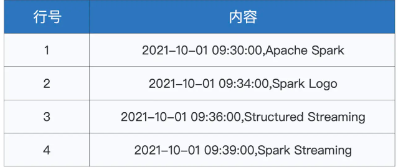

In [ ]:
import pyspark.sql.functions as F

HOST = 'netcat'  # 远程主机host
PORT = 9999         # 监听的端口号

# 1.数据加载
df = spark.readStream.format("socket").option("host", HOST).option("port", PORT).load()

# 2.数据处理
words = df.select(F.split("value", ",").alias("input"))
        .select(F.element_at("input", 1).alias("eventTime").cast("timestamp"), F.element_at("input", 2).alias("words"))
        .select("eventTime", F.explode(F.split("words", " ")).alias("word"))

wordCounts = words.groupBy(F.window("eventTime", "5 minute"), "word").count()

# 3. 数据输出：Word Count结果写入到终端（update）
query = wordCounts.writeStream.format("console").outputMode("update").start()

query.awaitTermination()

创建 Sliding Window 只需要window("eventTime", "5 minute", "3 minute")，创建出大小为 5 分钟，以 3 分钟为间隔的滑动窗口

### Late data 与 Watermark
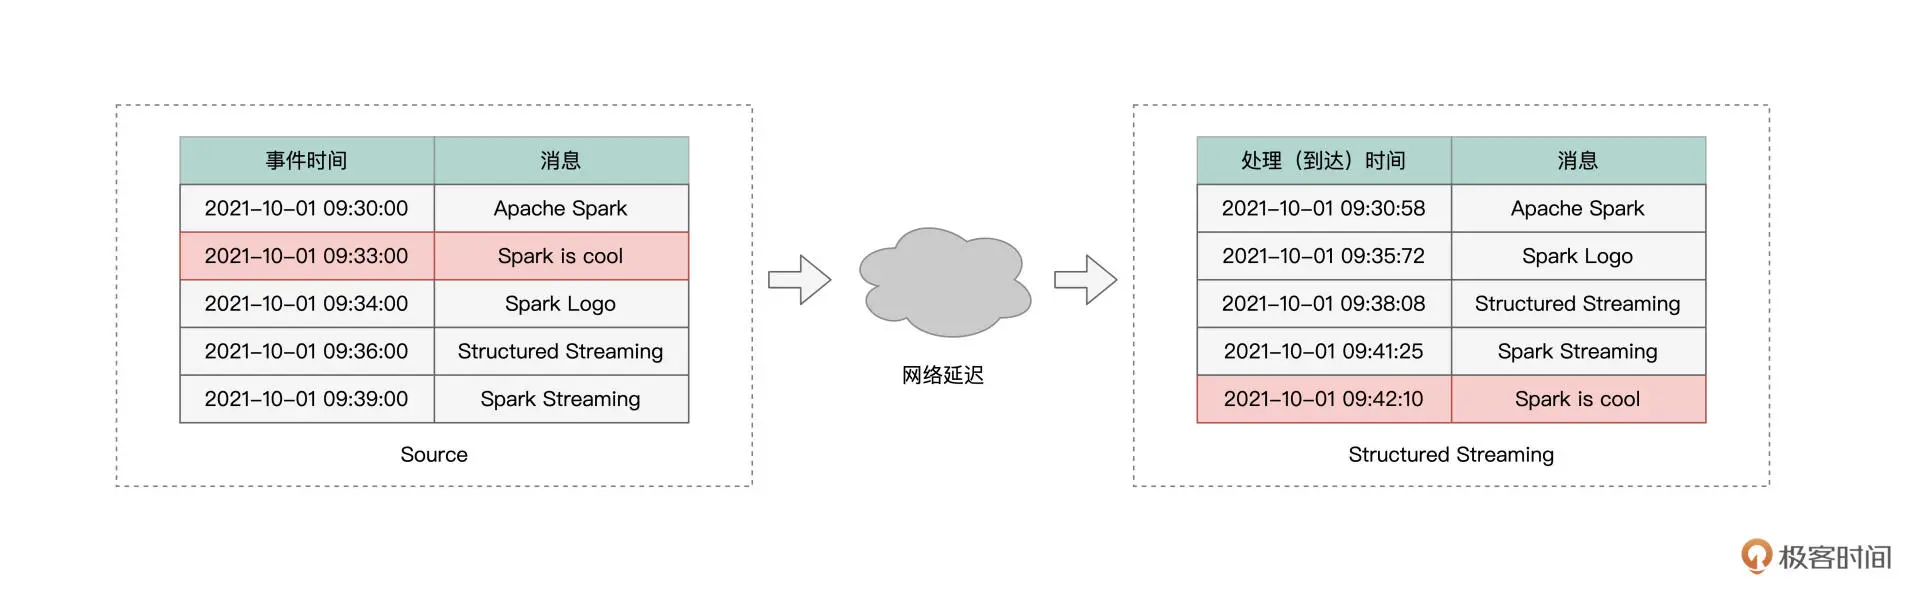
通常来说，消息生成的时间，与消息到达流处理引擎的时间，应该是一致的。也即先生成的消息先到达，而后生成的消息后到达，就像上图中灰色部分消息所示意的那样。

不过，在现实情况中，总会有一些消息，因为网络延迟或者这样那样的一些原因，它们的处理时间与事件时间存在着比较大的偏差。这些消息到达引擎的时间，甚至晚于那些在它们之后才生成的消息。像这样的消息，我们统称为“Late data”，如图中红色部分的消息所示。由于有 Late data 的存在，流处理引擎就需要一个机制，来判定 Late data 的有效性，从而决定是否让晚到的消息，参与到之前窗口的计算

就拿红色的“Spark is cool”消息来说，在它到达 Structured Streaming 引擎的时候，属于它的事件时间窗口“{2021-10-01 09:30:00, 2021-10-01 09:35:00}”已经关闭了。那么，在这种情况下，Structured Streaming 到底要不要用消息“Spark is cool”中的单词，去更新窗口 30-35 的状态（单词计数）呢

为了解决 Late data 的问题，Structured Streaming 采用了一种叫作 Watermark 的机制来应对，通过设置容忍度，决定“多迟”的消息可以被系统容忍并接受，更新之前窗口的计算结果

In [ ]:
# 启用Watermark机制，指定容忍度T为10分钟
withWatermark("eventTime", "10 minute")

## 流处理中的数据关联

在流计算的场景下，按照数据来源的不同，数据关联又可以分为“流批关联”与“双流关联”。所谓“流批关联”（Stream-Static Join），它指的是，参与关联的一张表，来自离线批数据，而另一张表的来源，是实时的数据流。换句话说，动态的实时数据流可以与静态的离线数据关联在一起，为我们提供多角度的数据洞察。
而“双流关联”（Stream-Stream Join），顾名思义，它的含义是，参与关联的两张表，都来自于不同的数据流，属于动态数据与动态数据之间的关联计算

### 流批关联

从一个实际场景出发解释流批关联的场景。在短视频流行的当下，推荐引擎扮演着极其重要的角色，而要想达到最佳的推荐效果，推荐引擎必须依赖用户的实时反馈。所谓实时反馈，其实就是我们习以为常的点赞、评论、转发等互动行为，不过，这里需要突出的，是一个“实时性”、或者说“及时性”。毕竟，在选择越来越多的今天，用户的兴趣与偏好，也在随着时间而迁移、变化，捕捉用户最近一段时间的兴趣爱好更加重要。一般来说，实时反馈来自线上的数据流，而用户属性这类数据，往往存储在离线数据仓库或是分布式文件系统。因此，用户实时反馈与用户属性信息的关联，正是典型的流批关联场景假设，


流数据是用户的实时互动信息，这里通过文件的形式来模拟线上的用户反馈作为 Structured Streaming的数据流来源

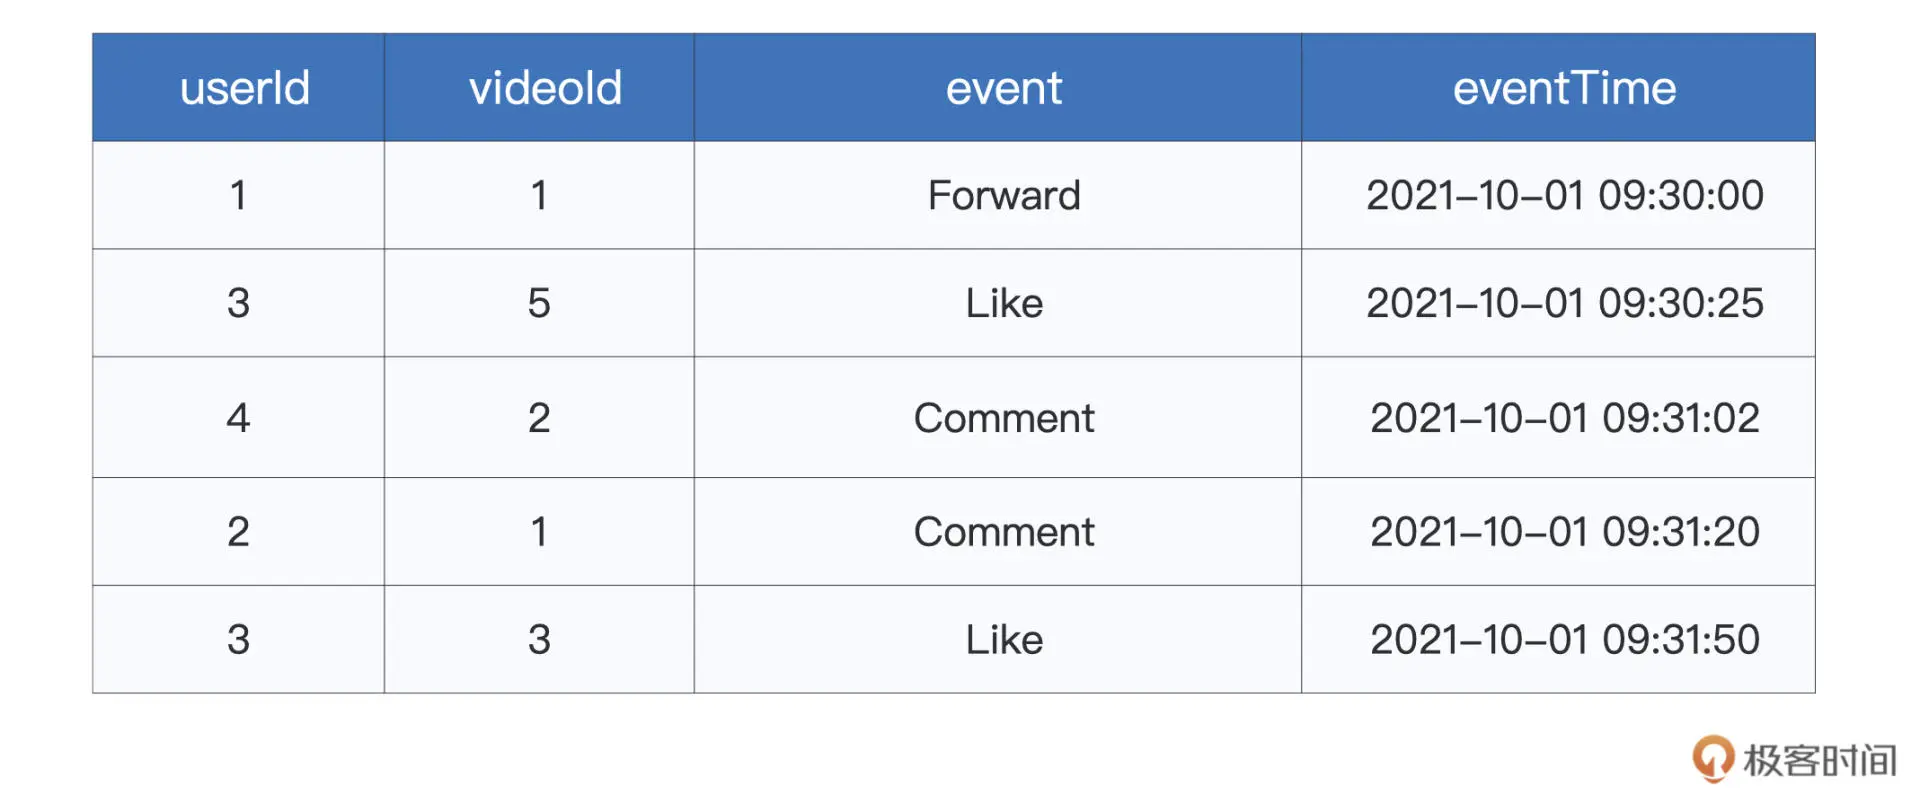

批数据是离线的用户属性，包含 id、name、age 与 gender 四个字段，同样使用本地文件系统来存放
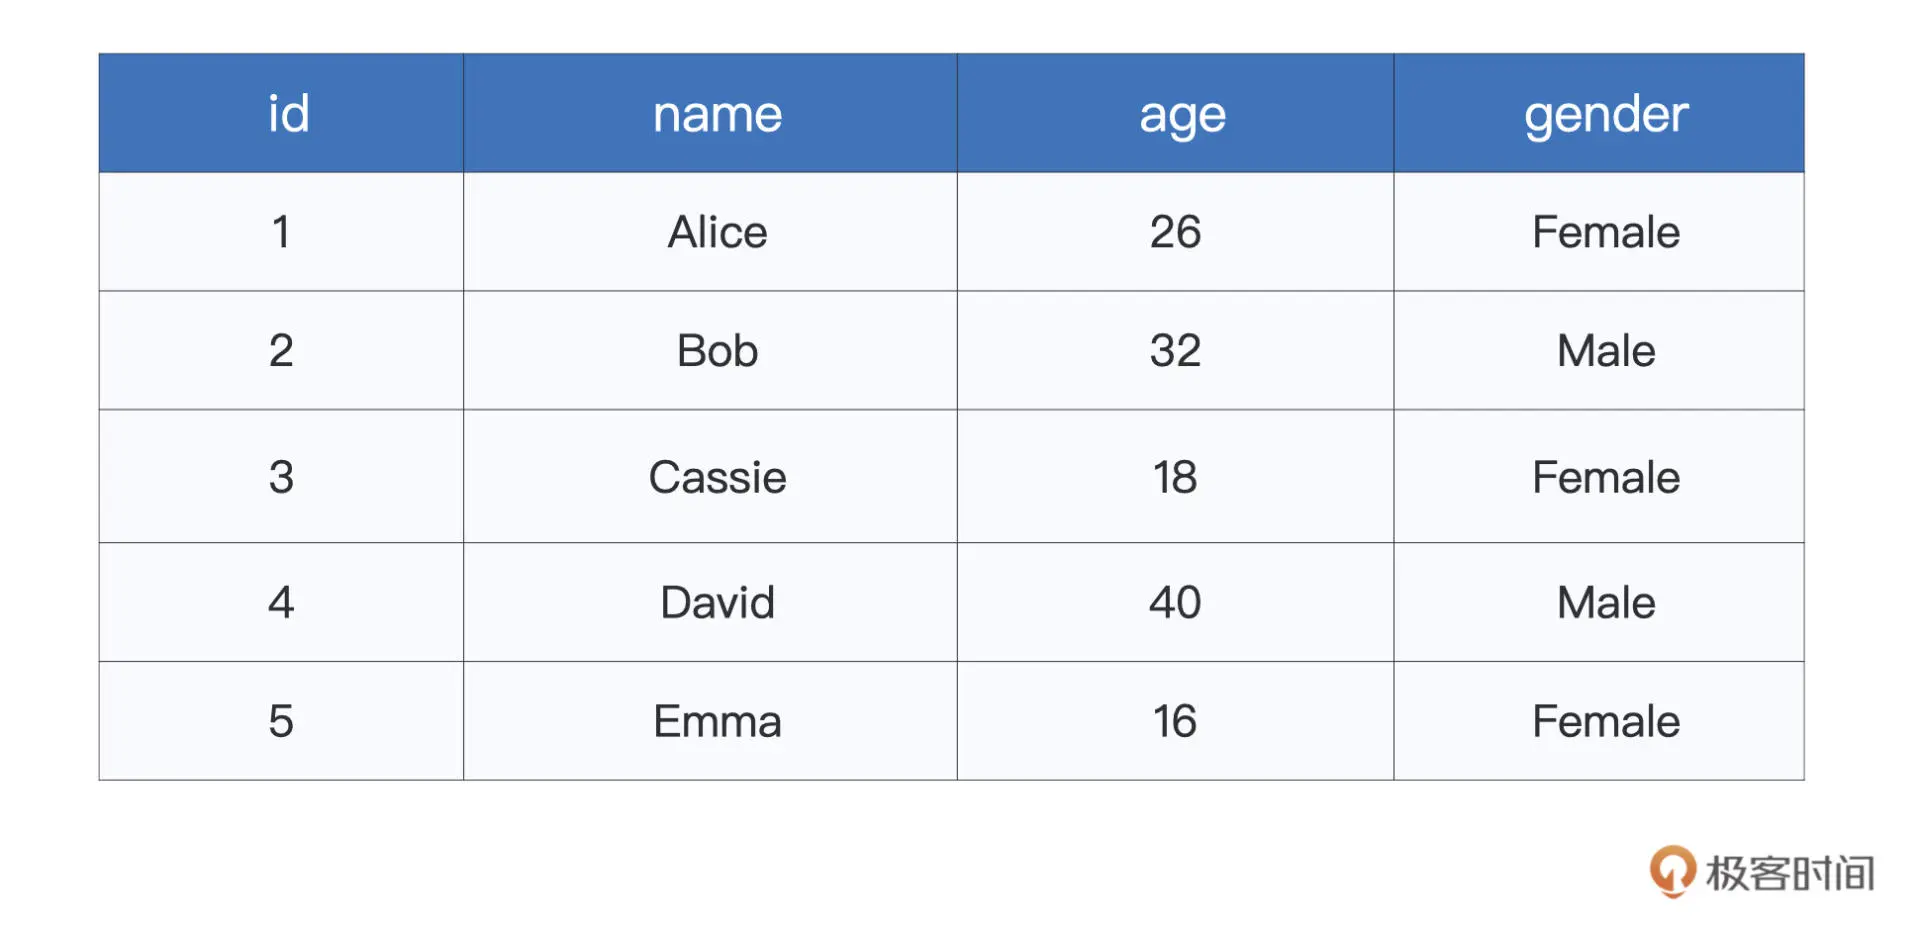

现在我们需要把离线的用户属性和实时的用户反馈相关联，从而建立用户特征向量。显然，在这个特征向量中，我们既想包含用户自身的属性字段，如年龄、性别、教育背景、职业，等等，更想包含用户的实时互动信息，比如 1 小时内的点赞数量、转发数量，等等，从而对用户进行更为全面的刻画

In [ ]:
rootPath = "../data"
streamingDF= spark.readStream.format("csv")
.option("header", True)
.option("path", f"{rootPath}/interactions")
.load()

一旦有新的数据内容进入{rootPath}/interactions 目录，Structured Streaming 便以流的形式，把新数据加载进来。通过事先把用户反馈文件，保存到临时的 staging 目录中，然后依次把文件拷贝到 interactions 目录，即可模拟数据流的生成。而用户属性信息本身就是离线数据，因此，我们把相关数据文件保存到 userProfile 目录即可
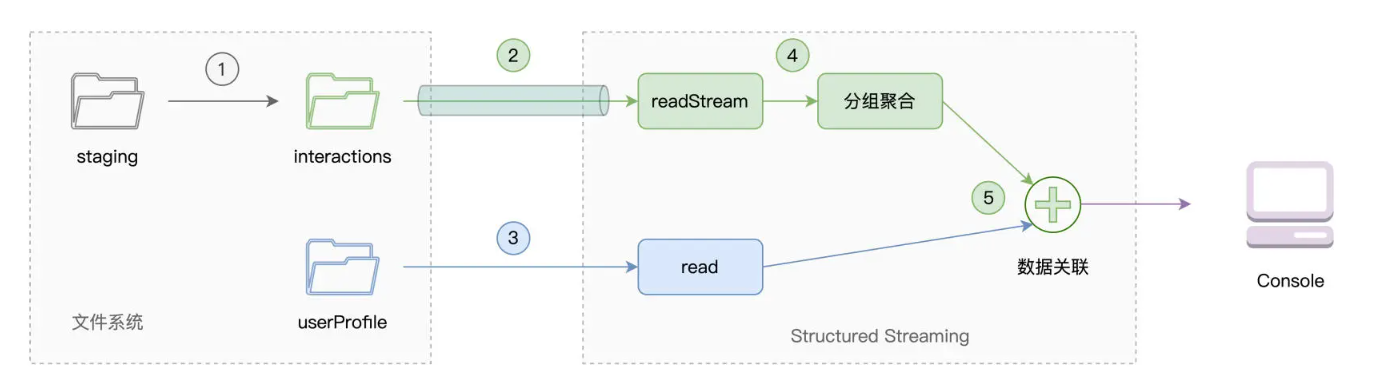

In [ ]:
from pyspark.sql.types import StructType

# 保存staging、interactions、userProfile等文件夹的根目录
rootPath = ""

# 使用read API读取离线数据，创建DataFrame
staticDF = spark.read.format("csv").option("header", True).load("{}/userProfile/userProfile.csv".format(rootPath))

# 定义用户反馈文件的Schema
actionSchema = StructType().add("userId", "integer").add("videoId", "integer").add("event", "string").add("eventTime", "timestamp")

# 使用readStream API加载数据流，注意对比readStream API与read API的区别与联系
streamingDF = spark.readStream.format("csv").option("header", True).option("path", "{}/interactions".format(rootPath)).schema(actionSchema).load()


In [ ]:
from pyspark.sql.functions import window, col

# 互动数据分组、聚合，只关心1小时的互动数据
streamingDF = streamingDF \
    .withWatermark("eventTime", "30 minutes") \
    .groupBy(window(col("eventTime"), "1 hours"), col("userId"), col("event")) \
    .count()

jointDF = streamingDF.join(staticDF, streamingDF["userId"] == staticDF["id"])


接下来执行代码，然后依次把 staging 文件夹中的 interactions*.csv 拷贝到 interactions 目录之下，来模拟数据流的生成，从而触发流批关联的计算  
[实例代码与数据下载](https://github.com/wulei-bj-cn/learn-spark/tree/main/chapter33)

### 双流关联
与流批关联相比，双流关联最主要的区别是数据来源的不同。除此之外，在双流关联中，事件时间的处理尤其关键

假设咱们有两个数据流，一个是短视频发布的数据流，其中记录着短视频相关的元信息，如 ID、Name 等等。另一个数据流是互动流，也就是用户对于短视频的互动行为。
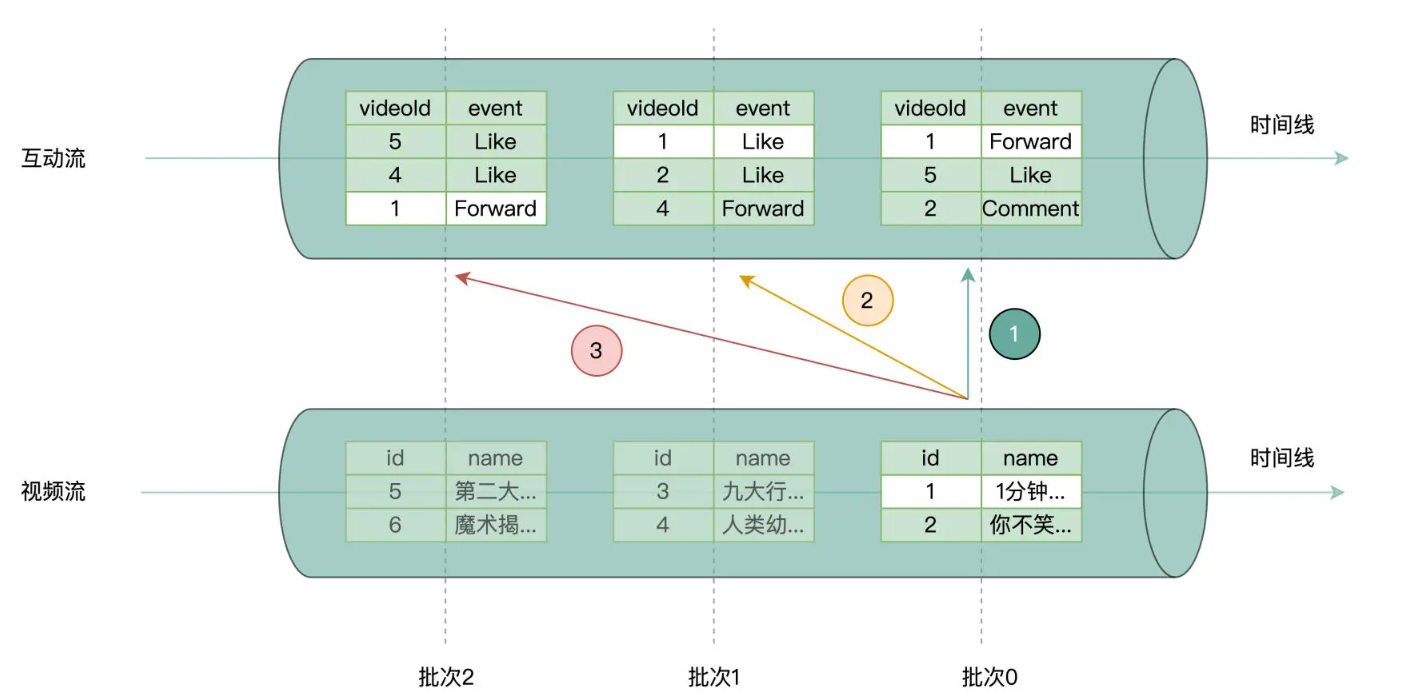

In [ ]:
from pyspark.sql.functions import expr

# 保存staging、interactions、userProfile等文件夹的根目录
rootPath = ""

# 定义视频流Schema
postSchema = StructType().add("id", "integer").add("name", "string").add("postTime", "timestamp")
# 监听videoPosting目录，以实时数据流的方式，加载新加入的文件
postStream = spark.readStream.format("csv").option("header", True).option("path", f"{rootPath}/videoPosting").schema(postSchema).load()
# 定义Watermark，设置Late data容忍度
postStreamWithWatermark = postStream.withWatermark("postTime", "5 minutes")

# 定义互动流Schema
actionSchema = StructType().add("userId", "integer").add("videoId", "integer").add("event", "string").add("eventTime", "timestamp")
# 监听interactions目录，以实时数据流的方式，加载新加入的文件
actionStream = spark.readStream.format("csv").option("header", True).option("path", f"{rootPath}/interactions").schema(actionSchema).load()
# 定义Watermark，设置Late data容忍度
actionStreamWithWatermark = actionStream.withWatermark("eventTime", "1 hours")

# 双流关联
jointDF = actionStreamWithWatermark.join(
    postStreamWithWatermark,
    expr("""
        videoId = id AND
        eventTime >= postTime AND
        eventTime <= postTime + interval 1 hour
    """)
)


可以看到，在关联条件中，除了要设置关联的主外键之外，还必须要对两张表各自的事件时间进行约束。其中，postTime 是视频流的事件时间，而 eventTime 是互动流的事件时间。上述代码的含义是，对于任意发布的视频流，我们只关心它一小时以内的互动行为，一小时以外的互动数据，将不再参与关联计算。这样一来，在 Watermark 机制的“保护”之下，事件时间的限制进一步降低了状态数据需要在内存中保存的时间，从而降低系统资源压力。

简言之，对于状态数据的维护，有了 Watermark 机制与事件时间的限制，可谓是加了“双保险”